# Machine Translation English to French using Seq2Seq Achitecture 

This project consists to create a model for machine translation english to french on a dataset available on kaggle [English to french translation](https://www.kaggle.com/code/harishreddy18/english-to-french-translation/data). The dataset contains sentences in english and the corresponding traduction in french. 137860 samples are contained in the dataset.

The Seq2Seq (sequence to sequence) with RNN is used for this task as an improvement for the standard word2word architecture.  

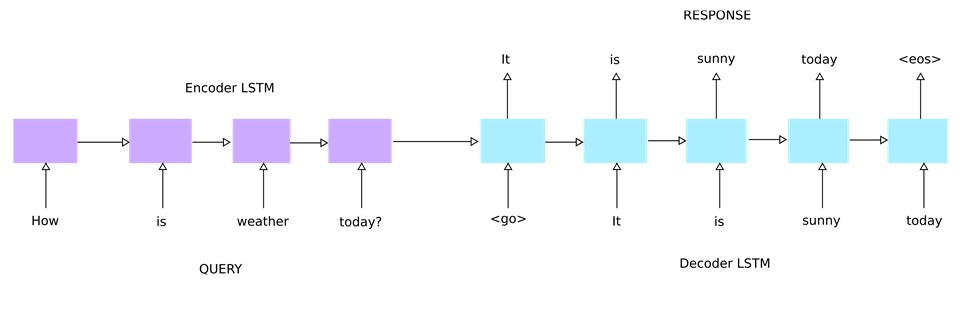

In [2]:
from IPython import display
display.Image("/content/drive/MyDrive/data/RNN_seq2seq.jpg")

## Modules import

In [2]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 

import os
import collections

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional, Dropout, LSTM

## Load dataset

In [3]:
## Data URLs
english_path='https://raw.githubusercontent.com/projjal1/datasets/master/small_vocab_en.txt'
french_path='https://raw.githubusercontent.com/projjal1/datasets/master/small_vocab_fr.txt'

## Data download with keras and storage in file system
english_data=tf.keras.utils.get_file('file1',english_path)
french_data=tf.keras.utils.get_file('file2',french_path)

## Loading data from file system
def load_data(path):
    input_file = os.path.join(path)
    with open(input_file, "r", encoding="utf-8") as file:
        data = file.read()

    return data.split('\n')

english_sentences=load_data(english_data)
french_sentences=load_data(french_data)

In [4]:
input_sentences = [txt for txt in  english_sentences]
output_sentences = [output + ' <eos>' for output in french_sentences]
output_sentences_inputs = ['<sos> ' + output for output in french_sentences]

## Data Preprocessing

### Display sample data

In [5]:
input_sentences[:5]

['new jersey is sometimes quiet during autumn , and it is snowy in april .',
 'the united states is usually chilly during july , and it is usually freezing in november .',
 'california is usually quiet during march , and it is usually hot in june .',
 'the united states is sometimes mild during june , and it is cold in september .',
 'your least liked fruit is the grape , but my least liked is the apple .']

In [6]:
output_sentences[:5]

["new jersey est parfois calme pendant l' automne , et il est neigeux en avril . <eos>",
 'les états-unis est généralement froid en juillet , et il gèle habituellement en novembre . <eos>',
 'california est généralement calme en mars , et il est généralement chaud en juin . <eos>',
 'les états-unis est parfois légère en juin , et il fait froid en septembre . <eos>',
 'votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme . <eos>']

In [7]:
output_sentences_inputs[:5]

["<sos> new jersey est parfois calme pendant l' automne , et il est neigeux en avril .",
 '<sos> les états-unis est généralement froid en juillet , et il gèle habituellement en novembre .',
 '<sos> california est généralement calme en mars , et il est généralement chaud en juin .',
 '<sos> les états-unis est parfois légère en juin , et il fait froid en septembre .',
 '<sos> votre moins aimé fruit est le raisin , mais mon moins aimé est la pomme .']

### Tokenization, Padding, Target one hot encoding

In [8]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

input_vocab_size = len(input_tokenizer.word_index)
  
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 199
Length of longest sentence in input: 15


In [9]:
output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

output_vocab_size = len(output_tokenizer.word_index)

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 356
Length of longest sentence in the output: 24


In [10]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

encoder_input_sequences.shape: (137860, 15)
encoder_input_sequences[172]: [ 0  0  0 22  1 10 57  4 38  6  3  1 68  2 33]


In [11]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

decoder_input_sequences.shape: (137860, 24)
decoder_input_sequences[172]: [  7  65 108 106  13  23  18  29  26  48   3   9   5   1  25  30  15  28
   2   0   0   0   0   0]


In [12]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[172]:", decoder_output_sequences[172])

decoder_output_sequences.shape: (137860, 24)
decoder_output_sequences[172]: [ 65 108 106  13  23  18  29  26  48   3   9   5   1  25  30  15  28   2
   6   0   0   0   0   0]


In [13]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

In [14]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

## Model building: LSTM Sequence to Sequence Architecture

In [15]:
LSTM_NODES = 128
EMBEDDING_SIZE=16

## Embedding layer
embedding_layer = tf.keras.layers.Embedding(input_vocab_size, EMBEDDING_SIZE, input_length=max_input_len)

## Encoder
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

## Decoder
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = tf.keras.layers.Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(decoder_inputs_x, initial_state=encoder_states)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs,
  decoder_inputs], decoder_outputs)

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


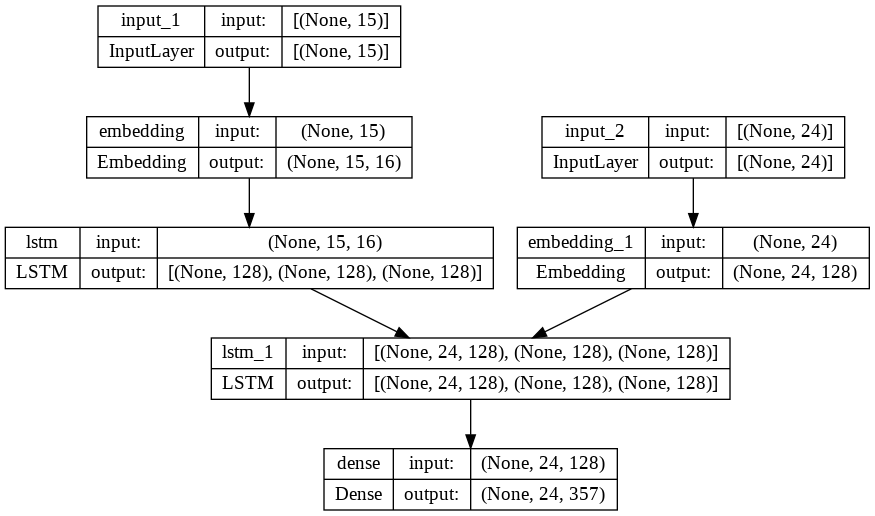

In [16]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

### Fitting the model

In [17]:
## Set seed for reproductibility
np.random.seed(42)
tf.random.set_seed(42)

history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=1024,
    epochs=50,
    validation_split=0.1,
)

Epoch 1/50
122/122 [==============================] - 14s 53ms/step - loss: 2.5782 - accuracy: 0.4679 - val_loss: 1.8628 - val_accuracy: 0.5912
Epoch 2/50
122/122 [==============================] - 5s 38ms/step - loss: 1.3096 - accuracy: 0.6812 - val_loss: 0.9337 - val_accuracy: 0.7397
Epoch 3/50
122/122 [==============================] - 5s 39ms/step - loss: 0.7955 - accuracy: 0.7542 - val_loss: 0.7117 - val_accuracy: 0.7659
Epoch 4/50
122/122 [==============================] - 5s 38ms/step - loss: 0.6636 - accuracy: 0.7730 - val_loss: 0.6302 - val_accuracy: 0.7801
Epoch 5/50
122/122 [==============================] - 5s 38ms/step - loss: 0.6037 - accuracy: 0.7858 - val_loss: 0.5796 - val_accuracy: 0.7929
Epoch 6/50
122/122 [==============================] - 5s 40ms/step - loss: 0.5645 - accuracy: 0.7960 - val_loss: 0.5547 - val_accuracy: 0.7956
Epoch 7/50
122/122 [==============================] - 5s 38ms/step - loss: 0.5382 - accuracy: 0.8033 - val_loss: 0.5292 - val_accuracy: 0.804

***High accuracy around 99%***

## Predictions

In [18]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

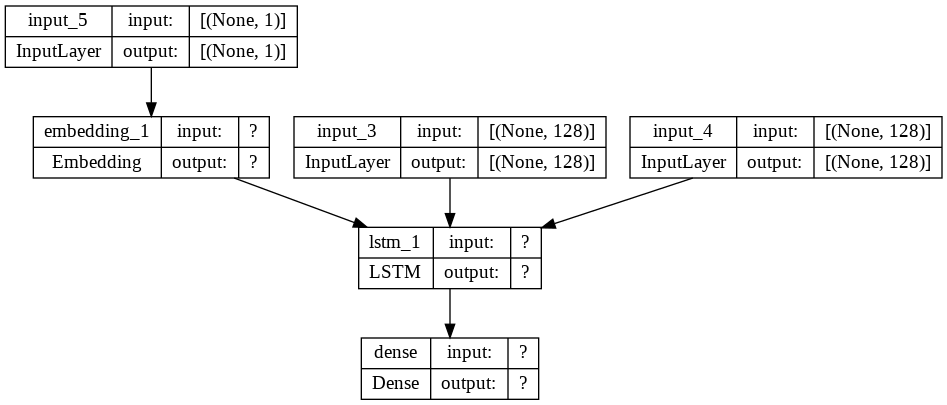

In [19]:
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [20]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [21]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

In [22]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 [==============================] - 0s 16ms/step
-
Input: my most loved fruit is the grapefruit , but her most loved is the banana .
Response: mon fruit le plus aimé est le pamplemousse , mais son plus aimé est la banane .


## Conclusion

Sequence to sequence archtecture with LSTM is the right choice for the current dataset. 99% accuracy is achieved with only 50 epochs and no model tuning. It is possible to achieve 100% accuracy, highly stable and quite perfect amodel.  